In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("../Data/E-Commerce_train.xlsx")
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
data['Warehouse_block'].value_counts()

F    2999
D    1500
A    1500
B    1500
C    1500
Name: Warehouse_block, dtype: int64

## Captamos los datos categoricos y numericos

#### Categoricos

In [4]:
categoricos = [cat for cat in data.columns if data[cat].dtype == 'object' and data[cat].nunique() <= 5]

In [5]:
categoricos

['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

#### Numericos

In [6]:
numericos = [num for num in data.columns if data[num].dtype != 'object']

In [7]:
numericos

['ID',
 'Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms',
 'Reached.on.Time_Y.N']

#### Eliminamos la columna ID la cual no ayudara en el modelo y tambien elimino la variable objetivo

In [8]:
numericos.remove("ID")
numericos.remove("Reached.on.Time_Y.N")
numericos.remove("Customer_rating")
#numericos.remove("Prior_purchases")


In [9]:
numericos

['Customer_care_calls',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms']

In [10]:
complet = numericos + categoricos

## Separamos en variable objetivo y caracteristicas

In [11]:
X = data[complet]
y = data['Reached.on.Time_Y.N']

## Separamos la data en datos de entrenamientos y de prueba

In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=1)

In [13]:
train_x.shape,test_x.shape, train_y.shape, test_y.shape

((6299, 9), (2700, 9), (6299,), (2700,))

## Funcion que estandarizacion y calcule el RECALL

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [15]:
def estandarizar(train,test):
    standar = StandardScaler()
    train_x_scaler = pd.DataFrame(standar.fit_transform(train))
    test_x_scaler = pd.DataFrame(standar.transform(test))
    train_x_scaler.columns = train.columns
    train_x_scaler.index = train.index
    test_x_scaler.columns = test.columns
    test_x_scaler.index = test.index
    return (train_x_scaler,test_x_scaler)

In [16]:
def evaluarModeloRL(train,test):
    modelo = LogisticRegression(random_state=1)
    modelo.fit(train,train_y)
    prediction = modelo.predict(test)
    return recall_score(test_y,prediction)

# Regresion Logistica

### Datos categoricos- OneHotEncoder

#### Manipulamos los datos categoricos

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
oneho = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [19]:
train_x_tr = pd.DataFrame(oneho.fit_transform(train_x[categoricos]))
test_x_tr = pd.DataFrame(oneho.transform(test_x[categoricos]))

In [20]:
train_x_tr.columns = ["Warehouse_block_a","Warehouse_block_b","Warehouse_block_c","Warehouse_block_d","Warehouse_block_f","Mode_of_Shipment_flight","Mode_of_Shipment_road","Mode_of_Shipment_ship","Product_importance_high","Product_importance_low","Product_importance_medium","Gender_F","Gender_M"]
test_x_tr.columns = ["Warehouse_block_a","Warehouse_block_b","Warehouse_block_c","Warehouse_block_d","Warehouse_block_f","Mode_of_Shipment_flight","Mode_of_Shipment_road","Mode_of_Shipment_ship","Product_importance_high","Product_importance_low","Product_importance_medium","Gender_F","Gender_M"]

In [21]:
train_x_tr.index = train_x.index
test_x_tr.index = test_x.index

In [22]:
train_x_t = train_x.drop(columns=categoricos)
test_y_t = test_x.drop(columns=categoricos)

In [23]:
train_x_c = pd.concat([train_x_t,train_x_tr],axis=1)
test_x_c = pd.concat([test_y_t,test_x_tr],axis=1)

#### Estandarizamos

In [24]:
train_x_scaler,test_x_scaler = estandarizar(train_x_c,test_x_c)

#### Modelamos y Evaluamos

In [25]:
evaluarModeloRL(train_x_scaler,test_x_scaler)

0.7575577949021932

### Datos categoricos- OrdinalEncoder

In [26]:
train_temp = train_x
test_temp = test_x

#### Manipular datos categoricos

In [27]:
from sklearn.preprocessing import OrdinalEncoder

In [28]:
ordinal = OrdinalEncoder()
train_temp[categoricos] = ordinal.fit_transform(train_temp[categoricos])
test_temp[categoricos] = ordinal.transform(test_temp[categoricos])

#### Estandarizamos

In [29]:
train_x_scaler2,test_x_scaler2 = estandarizar(train_temp,test_temp)

#### Ajustamos el modelo

In [30]:
evaluarModeloRL(train_x_scaler2,test_x_scaler2)

0.7569650266745702

# Arbol de decision

In [31]:
from sklearn.tree import DecisionTreeClassifier

#### Creamos una funcion para evaluar el modelo

In [32]:
def evaluar_tree(train,test,max,crite):
    modelo = DecisionTreeClassifier(random_state=1,max_depth=max,criterion=crite)
    modelo.fit(train,train_y)
    predic = modelo.predict(test)
    return recall_score(test_y,predic)

#### Creamos una funcion para la evaluacion real

In [33]:
def prediccion_real(train,test,max,crite):
    modelo = DecisionTreeClassifier(random_state=1,max_depth=max,criterion=crite)
    modelo.fit(train,train_y)
    predic = modelo.predict(test)
    return predic

#### Buscamos la mejor profundidad probando con el criterio GINI

### Usando OneHotEncoder

In [34]:
maxDepth_gini = []

In [35]:
for m in range(1,70,1):
    maxDepth_gini.append(evaluar_tree(train_x_scaler,test_x_scaler,m,'gini'))

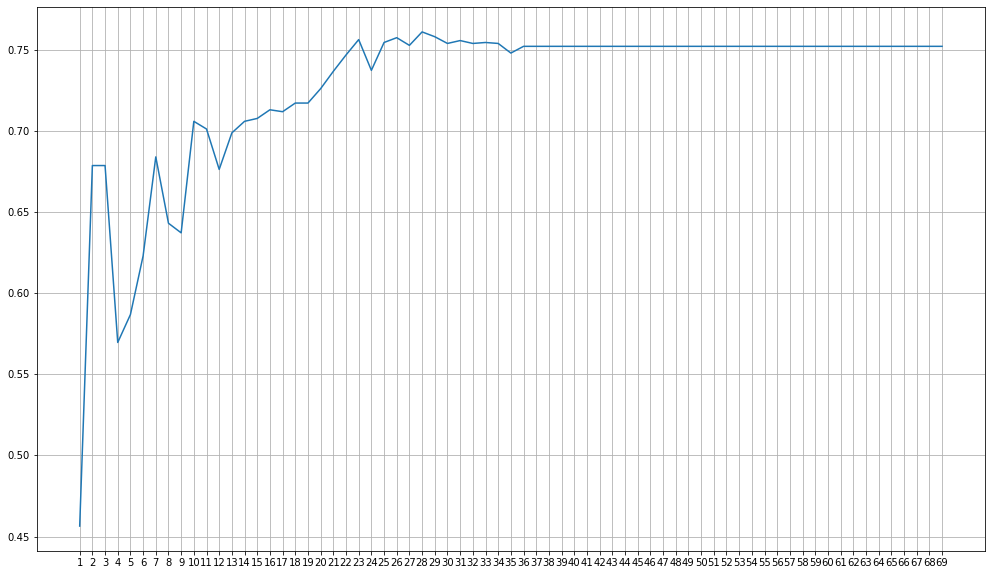

In [36]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_gini)
plt.xticks(range(1,70))
plt.grid()

La mejor opcion es de 25

In [37]:
max(maxDepth_gini)

0.7611144042679312

#### Buscamos la mejor profundidad probando con el criterio ENTROPY

In [38]:
maxDepth_entropy = []
for m in range(1,70,1):
    maxDepth_entropy.append(evaluar_tree(train_x_scaler,test_x_scaler,m,'entropy'))

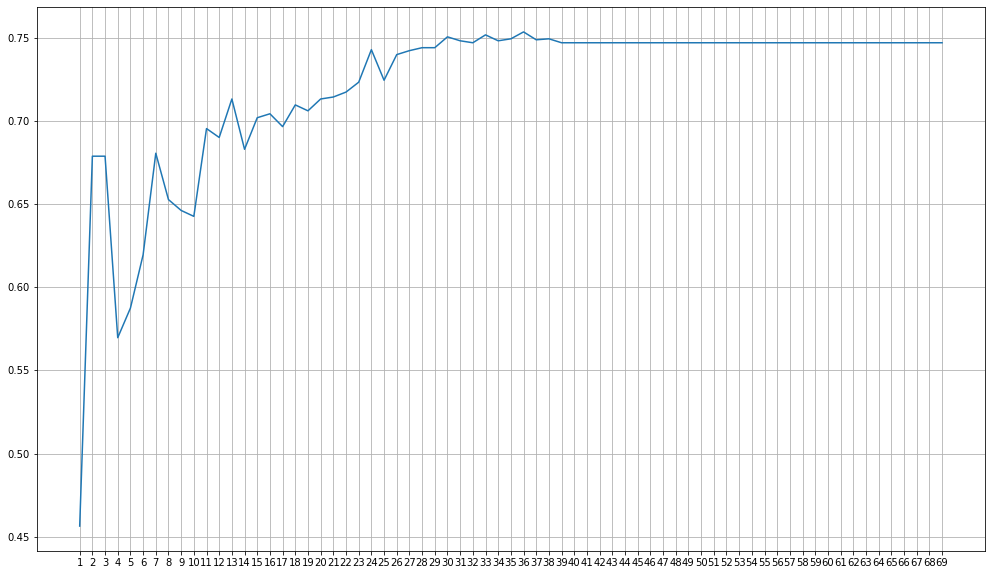

In [39]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_entropy)
plt.xticks(range(1,70))
plt.grid()

La mejor opcion es de 25

In [40]:
max(maxDepth_entropy)

0.7534084173088322

### Usando OrdinalEncoder

In [41]:
maxDepth_gini2 = []
for m in range(1,70,1):
    maxDepth_gini2.append(evaluar_tree(train_x_scaler2,test_x_scaler2,m,'gini'))

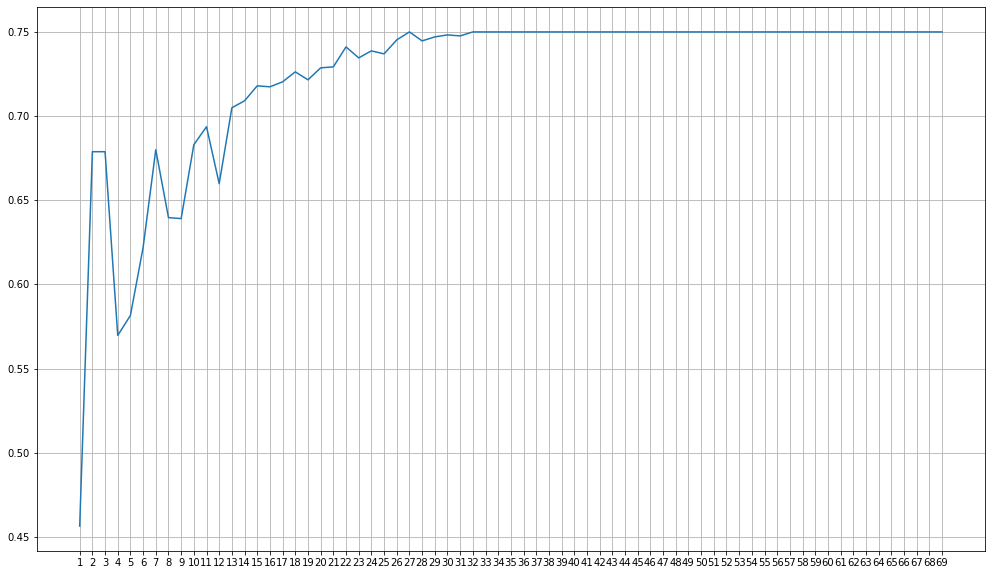

In [42]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_gini2)
plt.xticks(range(1,70))
plt.grid()

In [43]:
max(maxDepth_gini2)

0.7498518079430943

In [44]:
maxDepth_entropy2 = []
for m in range(1,70,1):
    maxDepth_entropy2.append(evaluar_tree(train_x_scaler2,test_x_scaler2,m,'entropy'))

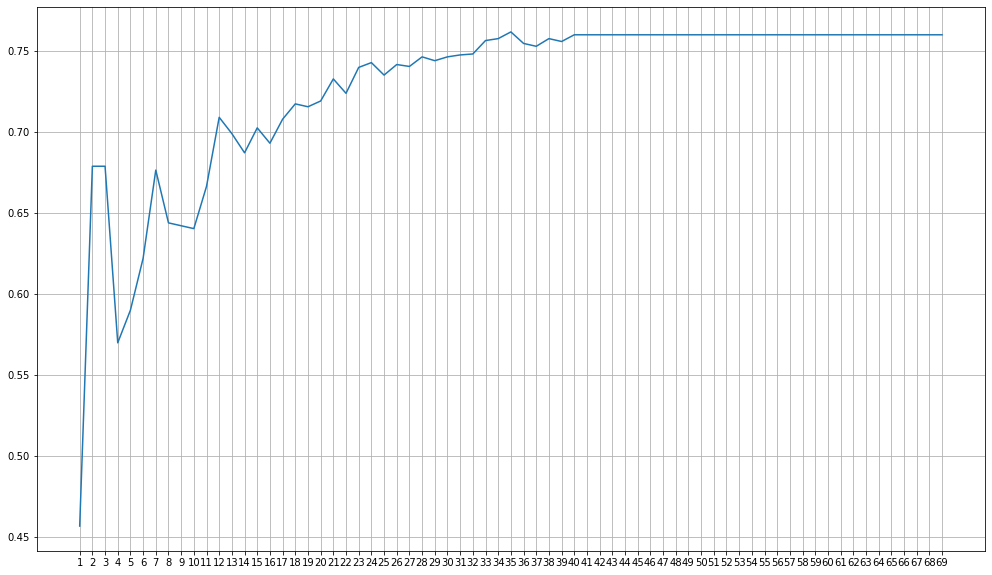

In [45]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_entropy2)
plt.xticks(range(1,70))
plt.grid()

In [46]:
max(maxDepth_entropy2)

0.7617071724955542

#### **> La mejor opcion es usando *OneHotEncoder, DecissionTreeClassifier, Entropy Y MAX_DEPTH=25(Por ahora) = 0.7572052401746725***

# Prediciendola data de E-Commerce_test.xlsx

In [47]:
ecommerce = pd.read_excel('../Data/E-Commerce_test.xlsx')

In [48]:
ecommerce.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,9000,F,Ship,5,1,189,2,medium,M,10,5248
1,9001,D,Ship,5,3,150,2,high,F,9,4446
2,9002,F,Ship,3,3,200,3,low,M,3,5739
3,9003,A,Ship,5,1,133,2,medium,M,1,4643
4,9004,B,Ship,4,2,260,3,low,M,4,5504


Elimino el ID

In [49]:
ecommerce.drop(columns=['ID'],inplace=True)

In [50]:
ecommerce[categoricos] = ordinal.fit_transform(ecommerce[categoricos])

In [51]:
ecommerce.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,4.0,2.0,5,1,189,2,2.0,1.0,10,5248
1,3.0,2.0,5,3,150,2,0.0,0.0,9,4446
2,4.0,2.0,3,3,200,3,1.0,1.0,3,5739
3,0.0,2.0,5,1,133,2,2.0,1.0,1,4643
4,1.0,2.0,4,2,260,3,1.0,1.0,4,5504


Transformo las variables categoricas

In [52]:
#test = pd.DataFrame(oneho.fit_transform(ecommerce[categoricos]))

Les cambio de nombre a las columnas

In [53]:
#test.columns =["Warehouse_block_a","Warehouse_block_b","Warehouse_block_c","Warehouse_block_d","Warehouse_block_f","Mode_of_Shipment_flight","Mode_of_Shipment_road","Mode_of_Shipment_ship","Product_importance_high","Product_importance_low","Product_importance_medium","Gender_F","Gender_M"]

Elimino las columnas categoricas anteriores

In [54]:
#ecommerce.drop(columns=categoricos,inplace=True)

Concateno los datos que quedaron de Ecommerce y los que me genero el OneHot en el dataFrame test

In [55]:
#final = pd.concat([ecommerce,test],axis=1)

Estandarizo los datos

In [56]:
standar = StandardScaler()
test_scaler = pd.DataFrame(standar.fit_transform(ecommerce))

In [57]:
test_scaler.columns = ecommerce.columns

In [58]:
test_scaler.drop(columns=['Customer_rating'],inplace=True)

In [59]:
test_scaler

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,1.117405,0.649981,0.676389,-0.616410,-1.251576,1.025842,1.005013,1.510350,0.814459
1,0.446493,0.649981,0.676389,-1.458294,-1.251576,-2.340333,-0.995012,1.165993,0.344728
2,1.117405,0.649981,-1.083894,-0.378956,-0.563897,-0.657246,1.005013,-0.900149,1.102038
3,-1.566246,0.649981,0.676389,-1.825269,-1.251576,1.025842,1.005013,-1.588863,0.460111
4,-0.895333,0.649981,-0.203753,0.916250,-0.563897,-0.657246,1.005013,-0.555792,0.964399
...,...,...,...,...,...,...,...,...,...
1995,-1.566246,0.649981,-0.203753,0.743556,0.811461,1.025842,-0.995012,-1.588863,-1.358489
1996,-0.895333,0.649981,-0.203753,0.311821,0.811461,1.025842,-0.995012,0.132922,-1.528928
1997,-0.224420,0.649981,0.676389,0.527688,0.811461,-0.657246,-0.995012,-0.555792,-1.582812
1998,1.117405,0.649981,0.676389,0.117540,1.499141,1.025842,1.005013,-1.244506,-1.550599


Realizo la prediccion con las variables que se evaluaron y dieron un mejor performance

In [60]:
prediccion_final = prediccion_real(train_x_scaler2,test_scaler,26,'gini')

c:\Users\tacas\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Creo mi dataFrame

In [61]:
df = pd.DataFrame({"pred":prediccion_final})

In [62]:
df

,pred
0,0
1,0
2,1
3,0
4,1
...,...
1995,1
1996,1
1997,1
1998,1


Guardo la data

In [63]:
df.to_csv("../Edward-Htc.csv",index=False)

# Segundo Avance

## Bosques Aleatorios

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#### Para no hacer tan engorroso el probar parametro por parametro usare **GridSearchCV**

In [65]:
parametros = {
    'forest': {
        #'random_state':[1],
        'n_estimators':range(5,40),
        'criterion' : ["gini", "entropy"],
        'max_depth' : range(5,40)
    }
}

In [66]:
forest = RandomForestClassifier(random_state=1)

OneHotEncoder

In [67]:
gridForest = GridSearchCV(forest,param_grid=parametros['forest'],scoring='recall')

In [68]:
gridForest.fit(train_x_scaler2,train_y)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 40),
                         'n_estimators': range(5, 40)},
             scoring='recall')

In [69]:
gridForest.best_score_

0.7487643786840333

In [70]:
gridForest.best_params_

{'criterion': 'gini', 'max_depth': 28, 'n_estimators': 5}

OrdinalEncoder

In [71]:
gridForest2 = GridSearchCV(forest,param_grid=parametros['forest'],scoring='recall')

In [72]:
gridForest2.fit(train_x_scaler2,train_y)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 40),
                         'n_estimators': range(5, 40)},
             scoring='recall')

In [73]:
gridForest2.best_score_

0.7487643786840333

In [74]:
gridForest2.best_params_

{'criterion': 'gini', 'max_depth': 28, 'n_estimators': 5}

**No vemos mejora en el resultado a comparacion de arbol de decision**

## KNeighbors

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
parametros_kn = {
    'n_neighbors' : range(1,10),
    'weights' : ('uniform','distance'),
    'algorithm' : ("auto", "ball_tree", "kd_tree", "brute")
}

In [77]:
modelknn = KNeighborsClassifier()

In [78]:
gridKNN = GridSearchCV(modelknn,param_grid=parametros_kn,scoring="recall")

In [79]:
gridKNN.fit(train_x_scaler,train_y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': range(1, 10),
                         'weights': ('uniform', 'distance')},
             scoring='recall')

In [80]:
gridKNN.best_score_

0.7266883134852915

In [81]:
gridKNN.best_params_

{'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}

#### OrdinalEncoder

In [82]:
gridKNN2 = GridSearchCV(modelknn,param_grid=parametros_kn,scoring="recall")

In [83]:
gridKNN2.fit(train_x_scaler2,train_y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': range(1, 10),
                         'weights': ('uniform', 'distance')},
             scoring='recall')

In [84]:
gridKNN2.best_score_

0.7289191042398862

## SVM

In [85]:
from sklearn.svm import SVC

In [86]:
parametros_svm = {
    'kernel':("linear", "poly", "rbf", "sigmoid"),
    'gamma' : ("scale","auto")
}

In [87]:
modelo_svc = SVC()

In [88]:
gridSVM = GridSearchCV(modelo_svc,parametros_svm,scoring='recall')

In [89]:
gridSVM.fit(train_x_scaler,train_y)

GridSearchCV(estimator=SVC(),
             param_grid={'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='recall')

In [90]:
gridSVM.best_score_

0.7390974137586441

In [91]:
gridSVM2 = GridSearchCV(modelo_svc,parametros_svm,scoring='recall')

In [92]:
gridSVM2.fit(train_x_scaler2,train_y)

GridSearchCV(estimator=SVC(),
             param_grid={'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='recall')

In [93]:
gridSVM2.best_score_

0.734379698727942